# Initializations etc.

## Imports

In [651]:
import math
import os

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img, array_to_img
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dropout, GlobalAveragePooling2D, Dense, Softmax, Activation, MaxPooling2D, Flatten, AveragePooling2D
from tensorflow.keras import Model, Sequential
from zipfile import ZipFile

!pip install -U tensorflow-addons
import tensorflow_addons as tfa

!pip install tqdm
from tqdm import tqdm_notebook as tqdm

Requirement already up-to-date: tensorflow-addons in /home/erikb/.pyenv/versions/3.8.2/envs/sci/lib/python3.8/site-packages (0.11.2)


## Globals

In [652]:
AUTO = tf.data.experimental.AUTOTUNE
IMG_WIDTH = 32
IMG_HEIGHT = 32
CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
CLASSES = 10
TOTAL_NUM_TRAIN_SAMPLES = 50000

# Datasets & Augmentations

In [756]:
##########
# Cutout #
##########
def cutout(image):
    size = tf.cast(
        tf.random.uniform([], minval=0, maxval=0.5) * IMG_WIDTH, tf.int32)
    if size <= 0:
        return image

    height_loc = tf.random.uniform([],
                                   minval=0,
                                   maxval=IMG_WIDTH,
                                   dtype=tf.int32)
    width_loc = tf.random.uniform([],
                                  minval=0,
                                  maxval=IMG_HEIGHT,
                                  dtype=tf.int32)
    image = tf.expand_dims(image, axis=0)
    image = tfa.image.random_cutout(image, size)
    return tf.squeeze(image)


######################
# Weak augmentations #
######################
def shift(image):
    pixels = tf.cast(
        tf.random.uniform([], minval=-0.125, maxval=0.125) * IMG_WIDTH,
        tf.int32)
    return tf.roll(image, [pixels, pixels], [0, 1])


def mirror(image):
    return tf.image.random_flip_left_right(image)


########################
# Strong augmentations #
########################
def autocontrast(image):
    def scale_channel(channel):
        lo = tf.cast(tf.reduce_min(channel), tf.float32)
        hi = tf.cast(tf.reduce_max(channel), tf.float32)

        def scale_values(im):
            scale = 255.0 / (hi - lo)
            offset = -lo * scale
            im = tf.cast(im, tf.float32) * scale + offset
            return tf.saturate_cast(im, tf.uint8)

        result = tf.cond(hi > lo, lambda: scale_values(channel),
                         lambda: channel)
        return result

    s1 = scale_channel(image[:, :, 0])
    s2 = scale_channel(image[:, :, 1])
    s3 = scale_channel(image[:, :, 2])
    image = tf.stack([s1, s2, s3], 2)
    return image


def brightness(image):
    factor = tf.random.uniform([], minval=0.05, maxval=0.95)
    degenerate = tf.zeros_like(image)
    return blend(degenerate, image, factor)


def color(image):
    factor = tf.random.uniform([], minval=0.05, maxval=0.95)
    degenerate = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
    return blend(degenerate, image, factor)


def contrast(image):
    factor = tf.random.uniform([], minval=0.05, maxval=0.95)
    grayscale_im = tf.image.rgb_to_grayscale(image)
    mean = tf.reduce_mean(tf.cast(grayscale_im, tf.float32))
    mean = tf.saturate_cast(mean + 0.5, tf.uint8)

    degenerate = tf.ones_like(grayscale_im, dtype=tf.uint8) * mean
    degenerate = tf.image.grayscale_to_rgb(degenerate)

    return blend(degenerate, image, factor)


def equalize(image):
    def scale_channel(im, c):
        im = tf.cast(im[:, :, c], tf.int32)

        histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)

        nonzero = tf.where(tf.not_equal(histo, 0))
        nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
        step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255

        def build_lut(histo, step):
            lut = (tf.cumsum(histo) + (step // 2)) // step
            lut = tf.concat([[0], lut[:-1]], 0)
            return tf.clip_by_value(lut, 0, 255)

        result = tf.cond(tf.equal(step, 0), lambda: im,
                         lambda: tf.gather(build_lut(histo, step), im))

        return tf.cast(result, tf.uint8)

    s1 = scale_channel(image, 0)
    s2 = scale_channel(image, 1)
    s3 = scale_channel(image, 2)
    image = tf.stack([s1, s2, s3], 2)
    return image


def identity(image):
    return image


def posterize(image):
    bits = tf.random.uniform([], minval=4, maxval=9, dtype=tf.int32)
    shift = tf.cast(8 - bits, image.dtype)
    return tf.bitwise.left_shift(tf.bitwise.right_shift(image, shift), shift)


def rotate(image):
    degrees = tf.random.uniform([], minval=-30, maxval=30)
    degrees_to_radians = math.pi / 180.0
    radians = degrees * degrees_to_radians

    image = tfa.image.transform_ops.rotate(wrap(image), radians)
    return unwrap(image)


def sharpness(image):
    factor = tf.random.uniform([], minval=0.05, maxval=0.95)
    orig_im = image
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, 0)
    kernel = tf.constant([[1, 1, 1], [1, 5, 1], [1, 1, 1]],
                         dtype=tf.float32,
                         shape=[3, 3, 1, 1]) / 13.
    kernel = tf.tile(kernel, [1, 1, 3, 1])
    strides = [1, 1, 1, 1]
    degenerate = tf.nn.depthwise_conv2d(image,
                                        kernel,
                                        strides,
                                        padding='VALID',
                                        dilations=[1, 1])
    degenerate = tf.squeeze(tf.saturate_cast(degenerate, tf.uint8), [0])

    mask = tf.ones_like(degenerate)
    padded_mask = tf.pad(mask, [[1, 1], [1, 1], [0, 0]])
    padded_degenerate = tf.pad(degenerate, [[1, 1], [1, 1], [0, 0]])
    result = tf.where(tf.equal(padded_mask, 1), padded_degenerate, orig_im)

    return blend(result, orig_im, factor)


def shear_x(image):
    level = tf.random.uniform([], minval=-0.3, maxval=0.3)
    image = tfa.image.transform_ops.transform(
        wrap(image), [1., level, 0., 0., 1., 0., 0., 0.])
    return unwrap(image)


def shear_y(image):
    level = tf.random.uniform([], minval=-0.3, maxval=0.3)
    image = tfa.image.transform_ops.transform(
        wrap(image), [1., 0., 0., level, 1., 0., 0., 0.])
    return unwrap(image)


def solarize(image):
    threshold = tf.random.uniform([], minval=0, maxval=255, dtype=tf.int32)
    threshold = tf.saturate_cast(threshold, image.dtype)
    return tf.where(image < threshold, image, 255 - image)


def translate_x(image):
    pixels = tf.cast(
        tf.random.uniform([], minval=-0.3, maxval=0.3) * IMG_WIDTH, tf.int32)
    image = tf.roll(image, [0, pixels], tf.constant([0, 1]))
    return image


def translate_y(image):
    pixels = tf.cast(
        tf.random.uniform([], minval=-0.3, maxval=0.3) * IMG_HEIGHT, tf.int32)
    image = tf.roll(image, [pixels, 0], tf.constant([0, 1]))
    return image


###########
# Utility #
###########
def blend(image1, image2, factor):
    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)
    return tf.saturate_cast(image1 + factor * (image2 - image1), tf.uint8)


def wrap(image):
    shape = tf.shape(image)
    extended_channel = tf.ones([shape[0], shape[1], 1], image.dtype)
    extended = tf.concat([image, extended_channel], 2)
    return extended


def unwrap(image):
    image_shape = tf.shape(image)
    flattened_image = tf.reshape(image, [-1, image_shape[2]])

    alpha_channel = tf.expand_dims(flattened_image[:, image_shape[2] - 1], 1)

    replace = tf.constant([128, 128, 128, 1], image.dtype)

    flattened_image = tf.where(
        tf.equal(alpha_channel, 0),
        tf.ones_like(flattened_image, dtype=image.dtype) * replace,
        flattened_image)

    image = tf.reshape(flattened_image, image_shape)
    image = tf.slice(image, [0, 0, 0],
                     [image_shape[0], image_shape[1], image_shape[2] - 1])
    return image


normalize_img = lambda x: tf.clip_by_value(x / 255, 0, 1)


####################################
# Augmentation selection functions #
####################################
def any_equals(x, y, v):
    return x == v or y == v


def augment_image_strong(image):
    num_funcs = tf.constant(14, dtype=tf.int32)
    func_num1 = tf.random.uniform([],
                                  minval=0,
                                  maxval=num_funcs,
                                  dtype=tf.int32)
    func_num2 = tf.random.uniform([],
                                  minval=0,
                                  maxval=num_funcs,
                                  dtype=tf.int32)

    while func_num1 == func_num2:
        func_num2 = tf.random.uniform([],
                                      minval=0,
                                      maxval=num_funcs,
                                      dtype=tf.int32)

    if any_equals(func_num1, func_num2, 0):
        image = autocontrast(image)
    if any_equals(func_num1, func_num2, 1):
        image = brightness(image)
    if any_equals(func_num1, func_num2, 2):
        image = color(image)
    if any_equals(func_num1, func_num2, 3):
        image = contrast(image)
    if any_equals(func_num1, func_num2, 4):
        image = equalize(image)
    if any_equals(func_num1, func_num2, 5):
        image = identity(image)
    if any_equals(func_num1, func_num2, 6):
        image = posterize(image)
    if any_equals(func_num1, func_num2, 7):
        image = rotate(image)
    if any_equals(func_num1, func_num2, 8):
        image = sharpness(image)
    if any_equals(func_num1, func_num2, 9):
        image = shear_x(image)
    if any_equals(func_num1, func_num2, 10):
        image = shear_y(image)
    if any_equals(func_num1, func_num2, 11):
        image = solarize(image)
    if any_equals(func_num1, func_num2, 12):
        image = translate_x(image)
    if any_equals(func_num1, func_num2, 13):
        image = translate_y(image)
    return image


def augment_image_weak(image):
    image = shift(image)
    image = mirror(image)
    return image


#####################
# Dataset splitting #
#####################
def x_u_split_idx(labels, num_labels_per_class):
    labeled = []
    unlabeled = []

    for i in range(CLASSES):
        idx = np.where(labels == i)[0]
        np.random.shuffle(idx)
        labeled.extend(idx[:num_labels_per_class])
        unlabeled.extend(idx)

    np.random.shuffle(labeled)
    np.random.shuffle(unlabeled)
    return labeled, unlabeled


def test_get_idx(labels, num_per_class, seed):
    test_idx = []

    for i in range(CLASSES):
        idx = np.where(labels == i)[0]
        if seed:
            np.random.seed(seed)
        np.random.shuffle(idx)
        test_idx.extend(idx[:num_per_class])

    return test_idx


def train_val_split(inputs, outputs, num_validation):
    num_classes = 10
    num_validation_per_class = num_validation // num_classes
    train_idx = []
    validation_idx = []

    for i in range(num_classes):
        idx = np.where(outputs == i)[0]
        np.random.shuffle(idx)
        train_idx.extend(idx[num_validation_per_class:])
        validation_idx.extend(idx[:num_validation_per_class])

    x_train = inputs[train_idx]
    y_train = outputs[train_idx]

    x_validation = inputs[validation_idx]
    y_validation = outputs[validation_idx]

    return (x_train, y_train), (x_validation, y_validation)


#################################
# Generate Train & Val Datasets #
#################################
def dataset_trainval(num_labels_per_class, batch_size, mu, validation_samples):
    (x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
    (x_train, y_train), (x_validation, y_validation) = train_val_split(
        x_train, y_train, validation_samples)
    (labeled_idx, unlabeled_idx) = x_u_split_idx(y_train, num_labels_per_class)

    total_batch_size = batch_size * (mu + 1)
    n_labeled_batches = math.ceil(num_labels_per_class * CLASSES / batch_size)
    n_unlabeled_batches = math.ceil(x_train.shape[0] / (batch_size * mu))
    n_val_batches = math.ceil(x_validation.shape[0] / total_batch_size)

    # Labeled
    y_labeled = tf.one_hot(y_train[labeled_idx].flatten(),
                           CLASSES,
                           dtype=tf.uint8)
    y_labeled = tf.data.Dataset.from_tensor_slices(y_labeled)
    x_labeled = x_train[labeled_idx]
    x_labeled = tf.data.Dataset.from_tensor_slices(x_labeled)
    x_labeled = x_labeled.map(augment_image_weak, num_parallel_calls=AUTO)
    x_labeled = x_labeled.map(normalize_img, num_parallel_calls=AUTO)
    labeled = tf.data.Dataset.zip(
        (x_labeled,
         y_labeled)).shuffle(batch_size * 8).batch(batch_size).repeat()

    # Unlabeled
    w_unlabeled = x_train[unlabeled_idx]
    w_unlabeled = tf.data.Dataset.from_tensor_slices(w_unlabeled)
    w_unlabeled = w_unlabeled.map(augment_image_weak, num_parallel_calls=AUTO)
    w_unlabeled = w_unlabeled.map(normalize_img, num_parallel_calls=AUTO)
    s_unlabeled = x_train[unlabeled_idx]
    s_unlabeled = tf.data.Dataset.from_tensor_slices(s_unlabeled)
    s_unlabeled = s_unlabeled.map(augment_image_strong,
                                  num_parallel_calls=AUTO)
    s_unlabeled = s_unlabeled.map(cutout, num_parallel_calls=AUTO)
    s_unlabeled = s_unlabeled.map(normalize_img, num_parallel_calls=AUTO)
    unlabeled = tf.data.Dataset.zip((w_unlabeled, s_unlabeled)).shuffle(
        batch_size * mu * 8).batch(batch_size * mu).repeat()

    # Validation
    y_validation = tf.one_hot(y_validation.flatten(), CLASSES, dtype=tf.uint8)
    y_validation = tf.data.Dataset.from_tensor_slices(y_validation)
    x_validation = tf.data.Dataset.from_tensor_slices(x_validation)
    x_validation = x_validation.map(augment_image_weak,
                                    num_parallel_calls=AUTO)
    x_validation = x_validation.map(normalize_img, num_parallel_calls=AUTO)
    validation = tf.data.Dataset.zip((x_validation, y_validation)).shuffle(
        total_batch_size * 8).batch(total_batch_size).repeat()

    return (labeled, n_labeled_batches), (unlabeled,
                                          n_unlabeled_batches), (validation,
                                                                 n_val_batches)


################################
# Generate Reular Test Dataset #
################################
def dataset_test(batch_size):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_test_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test
    y_test_ds = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_ds = tf.data.Dataset.from_tensor_slices(y_test_ds)
    x_test_ds = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_ds = x_test_ds.map(augment_image_weak, num_parallel_calls=AUTO)
    x_test_ds = x_test_ds.map(normalize_img, num_parallel_calls=AUTO)
    test = tf.data.Dataset.zip(
        (x_test_ds,
         y_test_ds)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test, n_test_batches)


###########################################
# Generate Reular Test Dataset with no WA #
###########################################
def dataset_test_no_wa(batch_size):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_test_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test
    y_test_ds = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_ds = tf.data.Dataset.from_tensor_slices(y_test_ds)
    x_test_ds = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_ds = x_test_ds.map(normalize_img, num_parallel_calls=AUTO)
    test = tf.data.Dataset.zip(
        (x_test_ds,
         y_test_ds)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test, n_test_batches)


##################################
# Generate Grad-CAM Test Dataset #
##################################
def dataset_test_gradcam(batch_size):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_test_grad_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test Grad-CAM
    y_test_grad = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_grad = tf.data.Dataset.from_tensor_slices(y_test_grad)
    x_test_grad_w = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_w = x_test_grad_w.map(augment_image_weak,
                                      num_parallel_calls=AUTO)
    x_test_grad_w = x_test_grad_w.map(normalize_img, num_parallel_calls=AUTO)
    x_test_grad_s = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_s = x_test_grad_s.map(augment_image_strong,
                                      num_parallel_calls=AUTO)
    x_test_grad_s = x_test_grad_s.map(cutout, num_parallel_calls=AUTO)
    x_test_grad_s = x_test_grad_s.map(normalize_img, num_parallel_calls=AUTO)
    test_grad = tf.data.Dataset.zip(
        (x_test_grad_w, x_test_grad_s,
         y_test_grad)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test_grad, n_test_grad_batches)


#######################################
# Generate Majority Vote Test Dataset #
#######################################
def dataset_test_vote(batch_size, repeats, func):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_repeats_batch_size = math.floor(batch_size / repeats) * repeats
    n_test_repeat_batches = math.ceil(x_test.shape[0] * repeats /
                                      n_repeats_batch_size)

    # Test Voting
    y_test_repeat = np.repeat(y_test, repeats, axis=0)
    y_test_ds_repeat = tf.one_hot(y_test_repeat.flatten(),
                                  CLASSES,
                                  dtype=tf.uint8)
    y_test_ds_repeat = tf.data.Dataset.from_tensor_slices(y_test_ds_repeat)
    x_test_repeat = np.repeat(x_test, repeats, axis=0)
    x_test_ds_repeat = tf.data.Dataset.from_tensor_slices(x_test_repeat)
    x_test_ds_repeat = x_test_ds_repeat.map(func, num_parallel_calls=AUTO)
    x_test_ds_repeat = x_test_ds_repeat.map(normalize_img,
                                            num_parallel_calls=AUTO)
    test_repeat = tf.data.Dataset.zip(
        (x_test_ds_repeat,
         y_test_ds_repeat)).batch(n_repeats_batch_size).shuffle(5).repeat()

    return (test_repeat, n_test_repeat_batches)


################################################
# Generate Grad-CAM Test Dataset fixed samples #
################################################
def dataset_test_gradcam_fixed(
    batch_size,
    n_samples_per_class,
    func1,
    func2,
    func3,
    seed=None,
    shuffle_classes=False,
    shuffle_class_seed=None,
):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    idx = test_get_idx(y_test, n_samples_per_class, seed)
    if shuffle_classes:
        if shuffle_class_seed:
            np.random.seed(shuffle_class_seed)
        np.random.shuffle(idx)
    x_test = x_test[idx]
    y_test = y_test[idx]

    n_test_grad_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test Grad-CAM
    y_test_grad = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_grad = tf.data.Dataset.from_tensor_slices(y_test_grad)
    x_test_grad_c = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_c = x_test_grad_c.map(func1, num_parallel_calls=AUTO)
    x_test_grad_c = x_test_grad_c.map(normalize_img, num_parallel_calls=AUTO)
    x_test_grad_w = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_w = x_test_grad_w.map(func2, num_parallel_calls=AUTO)
    x_test_grad_w = x_test_grad_w.map(normalize_img, num_parallel_calls=AUTO)
    x_test_grad_s = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_s = x_test_grad_s.map(func3, num_parallel_calls=AUTO)
    x_test_grad_s = x_test_grad_s.map(normalize_img, num_parallel_calls=AUTO)
    test_grad = tf.data.Dataset.zip(
        (x_test_grad_c, x_test_grad_w, x_test_grad_s,
         y_test_grad)).batch(batch_size).repeat()

    return (test_grad, n_test_grad_batches)


###########################################################
# Generate Reular Test Dataset with only one augmentation #
###########################################################
def dataset_test_single_augmentation(batch_size, augmentation):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_test_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test
    y_test_ds = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_ds = tf.data.Dataset.from_tensor_slices(y_test_ds)
    x_test_ds = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_ds = x_test_ds.map(augmentation, num_parallel_calls=AUTO)
    x_test_ds = x_test_ds.map(normalize_img, num_parallel_calls=AUTO)
    test = tf.data.Dataset.zip(
        (x_test_ds,
         y_test_ds)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test, n_test_batches)

# Wide-ResNet Implementation

In [654]:
def WideResNet(depth=28, widen_factor=2):
    filters = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
    strides = [1, 2, 2]
    assert ((depth - 4) % 6 == 0)
    n = (depth - 4) // 6

    inputs = Input(shape=IMG_SHAPE)
    x = Conv2D(filters[0],
               kernel_size=3,
               strides=1,
               padding='same',
               use_bias=False)(inputs)

    first_x = x
    orig_x = x

    for block_num in range(1, 4):
        activate_before_residual = True if block_num == 1 else False
        x = residual_block(x,
                           filters[block_num - 1],
                           filters[block_num],
                           strides[block_num - 1],
                           activate_before_residual=activate_before_residual)

        for i in range(1, n):
            x = residual_block(x,
                               filters[block_num],
                               filters[block_num],
                               1,
                               activate_before_residual=False)

        x, orig_x = res_add(filters[block_num - 1], filters[block_num],
                            strides[block_num - 1], x, orig_x)

    x, _ = res_add(filters[0], filters[3], np.prod(strides), x, first_x)

    x = BatchNormalization(momentum=0.999, scale=False, fused=True)(x)
    x = ReLU()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(CLASSES)(x)
    x = Softmax()(x)

    model = Model(inputs=inputs, outputs=x)
    return model


def residual_block(x,
                   in_filter,
                   out_filter,
                   stride,
                   activate_before_residual=False):
    if activate_before_residual:
        x = BatchNormalization(momentum=0.999, scale=False, fused=True)(x)
        x = ReLU()(x)
        orig_x = x
    else:
        orig_x = x

    block_x = x
    if not activate_before_residual:
        block_x = BatchNormalization(momentum=0.999, scale=False,
                                     fused=True)(block_x)
        block_x = ReLU()(block_x)

    block_x = Conv2D(out_filter,
                     kernel_size=3,
                     strides=stride,
                     padding='same',
                     use_bias=False)(block_x)

    block_x = BatchNormalization(momentum=0.999, scale=False,
                                 fused=True)(block_x)
    block_x = ReLU()(block_x)
    block_x = Conv2D(out_filter,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     use_bias=False)(block_x)

    if in_filter != out_filter:
        kernel = stride_arr(stride, stride)
        strides = stride_arr(stride, stride)
        orig_x = tf.nn.avg_pool(orig_x,
                                ksize=kernel,
                                strides=strides,
                                padding='VALID',
                                data_format='NHWC')
        orig_x = tf.pad(orig_x, [[0, 0], [0, 0], [0, 0],
                                 [(out_filter - in_filter) // 2,
                                  (out_filter - in_filter) // 2]])

    x = orig_x + block_x
    return x


def res_add(in_filter, out_filter, stride, x, orig_x):
    if in_filter != out_filter:
        kernel = stride_arr(stride, stride)
        strides = stride_arr(stride, stride)
        orig_x = tf.nn.avg_pool(orig_x,
                                ksize=kernel,
                                strides=strides,
                                padding='VALID',
                                data_format='NHWC')
        orig_x = tf.pad(orig_x, [[0, 0], [0, 0], [0, 0],
                                 [(out_filter - in_filter) // 2,
                                  (out_filter - in_filter) // 2]])

    x = x + orig_x
    orig_x = x
    return x, orig_x


def stride_arr(stride_h, stride_w):
    return [1, stride_h, stride_w, 1]

# Training/Loading Functions

In [655]:
def save_download_model(iteration):
    model_name = 'model_' + str(iteration)
    model_name_compressed = 'model_' + str(iteration) + '.zip'
    model.save(model_name)
    !zip -r $model_name_compressed $model_name


def save_download_stats(train_losses_labeled,
                        train_losses_unlabeled,
                        train_losses,
                        val_losses,
                        val_accuracies,
                        name='final'):
    file_name = 'stats_' + name + '.npz'
    np.savez_compressed(file_name,
                        tll=train_losses_labeled,
                        tlu=train_losses_unlabeled,
                        tl=train_losses,
                        vl=val_losses,
                        va=val_accuracies)


@tf.function
def train_step(x_labeled, y_labeled, w_unlabeled, s_unlabeled):
    with tf.GradientTape() as tape:
        # Logits
        logits_labeled = model(x_labeled, training=True)
        logits_w_unlabeled = model(w_unlabeled, training=True)
        logits_s_unlabeled = model(s_unlabeled, training=True)

        # Labeled loss
        loss_labeled = tf.keras.losses.categorical_crossentropy(
            y_labeled, logits_labeled)
        loss_labeled = tf.reduce_mean(loss_labeled)

        # Unlabeled loss
        pseudo_labels = tf.stop_gradient(logits_w_unlabeled)
        loss_unlabeled = tf.keras.losses.categorical_crossentropy(
            tf.one_hot(tf.argmax(pseudo_labels, axis=-1),
                       CLASSES,
                       dtype=tf.int8), logits_s_unlabeled)
        pseudo_mask = (tf.reduce_max(pseudo_labels, axis=1) >= TAU)
        pseudo_mask = tf.cast(pseudo_mask, tf.float32)
        loss_unlabeled = tf.reduce_mean(loss_unlabeled * pseudo_mask)

        # Total loss
        total_loss = loss_labeled + LAMBDA_U * loss_unlabeled

    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_labeled, loss_unlabeled, total_loss


@tf.function
def validation_step(x_validation, y_validation):
    logits = model(x_validation, training=False)
    loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(y_validation, logits))
    predictions = tf.argmax(logits, axis=-1)
    targets = tf.argmax(y_validation, axis=-1)
    accuracy = tf.reduce_mean(
        tf.cast(tf.equal(predictions, targets), tf.float32))
    return loss, accuracy


@tf.function
def test_step(x_test, y_test):
    logits = model(x_test, training=False)
    predictions = tf.argmax(logits, axis=-1)
    targets = tf.argmax(y_test, axis=-1)
    accuracy = tf.reduce_mean(
        tf.cast(tf.equal(predictions, targets), tf.float32))
    return accuracy


def lr_schedule(k):
    return LR * tf.cos((7 * math.pi * k) / (16 * ITERATIONS))


def run_train(labeled,
              unlabeled,
              validation,
              model_name='final'):
    # Progress bar
    pbar = tqdm(range(ITERATIONS))

    # Statistics
    train_losses_labeled = np.zeros((ITERATIONS))
    train_losses_unlabeled = np.zeros((ITERATIONS))
    train_losses = np.zeros((ITERATIONS))
    val_losses = np.zeros((math.ceil(ITERATIONS / VAL_PRINT_STEP)))
    val_accuracies = np.zeros((math.ceil(ITERATIONS / VAL_PRINT_STEP)))

    # Data
    (labeled, n_labeled_batches) = labeled
    (unlabeled, n_unlabeled_batches) = unlabeled
    (validation, n_val_batches) = validation

    # Iterations
    for (iteration, x_batch, u_batch) in zip(pbar, labeled, unlabeled):
        (x_labeled, y_labeled) = x_batch
        (w_unlabeled, s_unlabeled) = u_batch
        loss_labeled, loss_unlabeled, total_loss = train_step(
            x_labeled, y_labeled, w_unlabeled, s_unlabeled)

        train_losses_labeled[iteration] = loss_labeled
        train_losses_unlabeled[iteration] = loss_unlabeled
        train_losses[iteration] = total_loss

        optimizer.learning_rate.assign(lr_schedule(iteration))
        pbar.set_description('Train Loss: %.6f' % total_loss)

        # Validation
        if iteration % VAL_PRINT_STEP == 0:
            val_loss, val_accuracy = [], []
            for (i, (x_val, y_val)) in zip(range(n_val_batches), validation):
                val_batch_loss, val_batch_accuracy = validation_step(
                    x_val, y_val)
                val_loss.append(val_batch_loss)
                val_accuracy.append(val_batch_accuracy)
            val_loss_mean, val_accuracy_mean = np.mean(val_loss), np.mean(
                val_accuracy)
            val_losses[iteration // VAL_PRINT_STEP] = val_loss_mean
            val_accuracies[iteration // VAL_PRINT_STEP] = val_accuracy_mean

    save_download_model(model_name)
    return train_losses_labeled, train_losses_unlabeled, train_losses, val_losses, val_accuracies


def run_test(test, n_test_batches):
    test_accuracy = []
    for (i, (x_test, y_test)) in zip(range(n_test_batches), test):
        logits = model(x_test, training=False)
        predictions = tf.argmax(logits, axis=-1)
        targets = tf.argmax(y_test, axis=-1)
        test_batch_accuracy = tf.reduce_mean(
            tf.cast(tf.equal(predictions, targets), tf.float32))
        test_accuracy.append(test_batch_accuracy)
    return np.mean(test_accuracy)


def run_test_vote(test, n_test_batches):
    test_accuracy = []
    for (i, (x_test, y_test)) in zip(range(n_test_batches), test):
        logits = model(x_test, training=False)
        predictions = tf.argmax(logits, axis=-1)
        targets = tf.argmax(y_test, axis=-1)
        imgs_in_batch = tf.math.floordiv(
            tf.gather_nd(tf.shape(predictions), [0]), repeats)
        image_split = tf.fill((imgs_in_batch, ), repeats)
        split_preds = tf.split(predictions, image_split)
        split_labels = tf.split(targets, image_split)
        for (img_preds, img_labels) in zip(split_preds, split_labels):
            y, _, count = tf.unique_with_counts(img_preds)
            accuracy = tf.reduce_mean(
                tf.cast(
                    tf.equal(tf.fill((1, ), y[tf.argmax(count)]), img_labels),
                    tf.float32))
            test_accuracy.append(accuracy)
    return tf.reduce_mean(test_accuracy)


def load_model(model_name):
    model_name = 'model_' + model_name
    if not os.path.exists(model_name):
        with ZipFile(model_name + '.zip', 'r') as zipfile:
            zipfile.extractall()

    return tf.keras.models.load_model(model_name)

## Training Run

In [15]:
# Hyper-params
LAMBDA_U = 1
TAU = 0.95
MU = 2
LR = 0.03
ITERATIONS = 40000
BATCH_SIZE = 64
LABELS_PER_CLASS = 25
WD = 0.00005
VAL_PRINT_STEP = 100
model_name = 'mu2'

# Data
NUM_VAL_SAMPLES = 1000
num_training_samples = TOTAL_NUM_TRAIN_SAMPLES - NUM_VAL_SAMPLES
labeled, unlabeled, validation = dataset_trainval(LABELS_PER_CLASS, BATCH_SIZE,
                                                  MU, NUM_VAL_SAMPLES)

# Model and training
sgdw = tfa.optimizers.SGDW(learning_rate=LR,
                           momentum=0.9,
                           nesterov=True,
                           weight_decay=WD)
optimizer = tfa.optimizers.MovingAverage(sgdw, average_decay=0.999)
model = WideResNet()

# Train
train_losses_labeled, train_losses_unlabeled, train_losses, val_losses, val_accuracies = run_train(
    labeled, unlabeled, validation, model_name=model_name)

# Save Stats
save_download_stats(train_losses_labeled,
                    train_losses_unlabeled,
                    train_losses,
                    val_losses,
                    val_accuracies,
                    name=model_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_mu2/assets
  adding: model_mu2/ (stored 0%)
  adding: model_mu2/assets/ (stored 0%)
  adding: model_mu2/variables/ (stored 0%)
  adding: model_mu2/variables/variables.index (deflated 77%)
  adding: model_mu2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_mu2/saved_model.pb (deflated 93%)


# Evaluation

In [767]:
def custom_augment(image):
    image = mirror(image)
    image = posterize(image)
    return image

model = load_model('400_2')

batch_size = 512
repeats = 7
samples = 5

acc_no_a = np.zeros(samples)
acc_tta = np.zeros(samples)

(test_no_a, n_test_no_a_batches) = dataset_test_single_augmentation(batch_size, identity)
(test_repeat, n_test_repeat_batches) = dataset_test_vote(batch_size, repeats, custom_augment)

for i in tqdm(range(samples)):
    acc_no_a[i] = run_test(test_no_wa, n_test_no_wa_batches)
    acc_tta[i] = run_test_vote(test_repeat, n_test_repeat_batches)
print("Acc No augment.  Mean=" + str(acc_no_a.mean()) + "   std=" +
      str(acc_no_a.std()))
print("Acc TTA.    Mean=" + str(acc_tta.mean()) + "   std=" + str(acc_tta.std()))


Acc No augment.  Mean=0.8972713589668274   std=0.00025906753477900605
Acc TTA.    Mean=0.8970800042152405   std=0.00047917479969902365


## Plots

### Helper Functions

In [657]:
def tickrange(magnitudes):
    ticks = np.array([])
    for i in range(len(magnitudes) - 1):
        ticks = np.concatenate(
            (ticks, np.arange(magnitudes[i], magnitudes[i + 1],
                              magnitudes[i])))
    return ticks

### Variable Labels Experiment

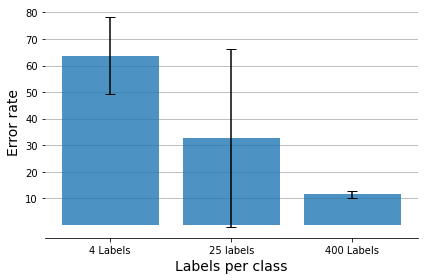

In [658]:
low_label_err = [64.61, 53.56, 63.25, 89.99, 47.32]
mid_label_err = [17.44, 15.59, 14.98, 15.55, 100]
high_label_err = [11.58, 10.32, 10.77, 10.96, 13.83]

low_label_err_mean = np.mean(low_label_err)
mid_label_err_mean = np.mean(mid_label_err)
high_label_err_mean = np.mean(high_label_err)
low_label_err_std = np.std(low_label_err)
mid_label_err_std = np.std(mid_label_err)
high_label_err_std = np.std(high_label_err)

label_amounts = ['4 Labels', '25 labels', '400 Labels']
x_pos = np.arange(len(label_amounts))
y_ticks = np.arange(80, 0, -10)
label_err_mean = [low_label_err_mean, mid_label_err_mean, high_label_err_mean]
std_dev = [low_label_err_std, mid_label_err_std, high_label_err_std]

fig, ax = plt.subplots()
ax.bar(x_pos,
       label_err_mean,
       yerr=std_dev,
       align='center',
       alpha=0.8,
       ecolor='black',
       capsize=5)
ax.set_ylabel('Error rate', fontsize=14)
ax.set_xlabel('Labels per class', fontsize=14)
ax.set_xticks(x_pos)
ax.set_yticks(y_ticks)
ax.set_xticklabels(label_amounts)
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Save the figure and show
plt.tight_layout()
plt.show()

### Weight Decay Ablation

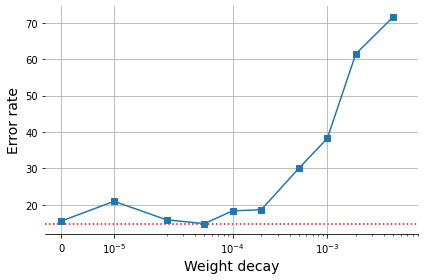

In [659]:
wd_ablation = [
    15.50, 20.94, 15.85, 14.79, 18.32, 18.61, 30.00, 38.24, 61.48, 71.69
]
wd_ablation_values = [
    0, 0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005
]

fig1, ax1 = plt.subplots()
ax1.plot(wd_ablation_values, wd_ablation, marker='s')
ax1.set_xscale('symlog', linthreshx=0.00002)
ax1.set_ylabel('Error rate', fontsize=14)
ax1.set_xlabel('Weight decay', fontsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.axhline(y=min(wd_ablation),
            xmin=0,
            xmax=1,
            color='red',
            linestyle=':',
            zorder=1)
ax1.set_xticks(tickrange([0.00001, 0.0001, 0.001, 0.01]), minor=True)
plt.grid()
plt.tight_layout()
plt.show()

### Mu Ablation

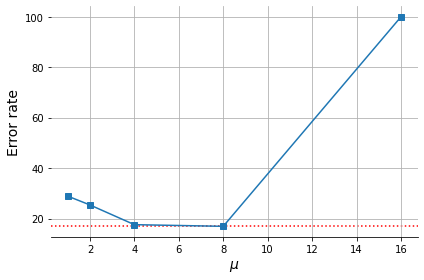

In [660]:
mu_ablation = [28.88, 25.38, 17.56, 16.90, 100]
mu_ablation_values = [1, 2, 4, 8, 16]

fig1, ax1 = plt.subplots()
ax1.plot(mu_ablation_values, mu_ablation, marker='s')
ax1.set_ylabel('Error rate', fontsize=14)
ax1.set_xlabel('$\mu$', fontsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.axhline(y=min(mu_ablation),
            xmin=0,
            xmax=1,
            color='red',
            linestyle=':',
            zorder=1)
plt.grid()
plt.tight_layout()
plt.show()

### Augmentation Effect

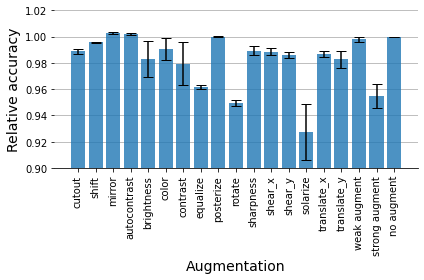

In [749]:
low_label_err = [
    0.9863945578, 0.9961904762, 1.001904762, 1.002721088, 0.9632653061,
    0.9785034014, 0.9561904762, 0.9640816327, 1.000544218, 0.9531972789,
    0.9844897959, 0.9921088435, 0.9831292517, 0.8976870748, 0.9904761905,
    0.973877551, 0.9953741497, 0.9420408163, 1
]
mid_label_err = [
    0.9903435886, 0.9956209297, 1.003368516, 1.001347406, 0.9929261172,
    0.9967437682, 0.9910172917, 0.9608129351, 0.9998877161, 0.9477880081,
    0.9916909948, 0.986975073, 0.9875364923, 0.9426229508, 0.9849539636,
    0.9873119245, 0.9991017292, 0.9611497867, 1
]
high_label_err = [
    0.9903435886, 0.9956209297, 1.003368516, 1.001347406, 0.9929261172,
    0.9967437682, 0.9910172917, 0.9608129351, 0.9998877161, 0.9477880081,
    0.9916909948, 0.986975073, 0.9875364923, 0.9426229508, 0.9849539636,
    0.9873119245, 0.9991017292, 0.9611497867, 1
]

n_augmentations = 19

augmentations_mean = np.zeros((n_augmentations))
augmentations_std = np.zeros((n_augmentations))

for i in range(n_augmentations):
    augmentations_mean[i] = np.mean(
        [low_label_err[i], mid_label_err[i], high_label_err[i]])
    augmentations_std[i] = np.std(
        [low_label_err[i], mid_label_err[i], high_label_err[i]])

label_amounts = [
    'cutout', 'shift', 'mirror', 'autocontrast', 'brightness', 'color', 'contrast',
    'equalize', 'posterize', 'rotate', 'sharpness', 'shear_x', 'shear_y',
    'solarize', 'translate_x', 'translate_y', 'weak augment', 'strong augment',
    'no augment'
]
x_pos = np.arange(len(label_amounts))
y_ticks = np.arange(0.85, 1.10, 0.05)
fig, ax = plt.subplots()
ax.bar(x_pos,
       augmentations_mean,
       yerr=augmentations_std,
       align='center',
       alpha=0.8,
       ecolor='black',
       capsize=5)
ax.set_ylabel('Relative accuracy', fontsize=14)
ax.set_xlabel('Augmentation', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(label_amounts, rotation=90)
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.set_ylim(0.9, 1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Save the figure and show
plt.tight_layout()
plt.show()

## Augmentation Effect on Performance

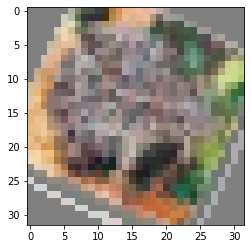

In [662]:
(test, n_test_batches) = dataset_test_single_augmentation(batch_size, rotate)
(img, _) = next(iter(tfds.as_numpy(test.unbatch().batch(1).take(1))))
plt.imshow(img[0])

In [748]:
model = load_model('400_4')

func = mirror
batch_size = 512
samples = 5

acc = np.zeros(samples)
(test, n_test_batches) = dataset_test_single_augmentation(batch_size, func)
for i in tqdm(range(samples)):
    acc[i] = run_test(test, n_test_batches)

print("Mean=" + str(acc.mean()) + "   std=" + str(acc.std()))


Mean=0.893551254272461   std=0.0003323142835635153


# Grad-CAM Functions

In [698]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
            return layer
    raise ValueError("Could not find conv layer. Cannot apply GradCAM.")


def make_gradcam_heatmap(images_array, model):
    last_conv_layer = find_last_conv_layer(model)

    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    after_last_conv = False
    classifier_layer_names = []
    for layer in model.layers:
        if after_last_conv:
            classifier_layer_names.append(layer.name)
        elif find_last_conv_layer(model).name == layer.name:
            after_last_conv = True

    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(images_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds, axis=1)
        one_hot_mask = tf.one_hot(
            top_pred_index,
            preds.shape[1],
            on_value=True,
            off_value=False,
            dtype=tf.bool,
        )
        top_class_channel = tf.boolean_mask(preds, one_hot_mask)

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[0]):
        for j in range(pooled_grads.shape[-1]):
            last_conv_layer_output[i, :, :, j] *= pooled_grads[i, j]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    max_heatmap = np.maximum(heatmap, 0)
    for i in range(pooled_grads.shape[0]):
        heatmap[i] = max_heatmap[i] / np.max(heatmap[i])

    return heatmap


def combine_heatmap_image(image_array, heatmap):
    image_array = np.uint8(255 * image_array)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]

    superimposed_imgs = np.zeros(image_array.shape)
    for i, (hm, im) in enumerate(zip(heatmap, image_array)):
        jet_heatmap = jet_colors[hm]

        jet_heatmap = array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize(
            (image_array.shape[1], image_array.shape[2]))
        jet_heatmap = img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * 0.6 + im
        superimposed_img = array_to_img(superimposed_img)
        superimposed_imgs[i] = superimposed_img

    return superimposed_imgs / 255

## Grad-CAM Experiments

In [753]:
model = load_model('400_2')
(test_grad,
 n_test_grad_batches) = dataset_test_gradcam_fixed(10,
                                                   1,
                                                   identity,
                                                   autocontrast,
                                                   solarize,
                                                   shuffle_classes=True)

# interesting stuff
# seed 12, class seed 6

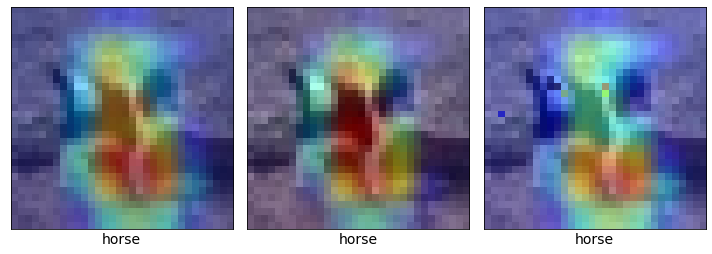

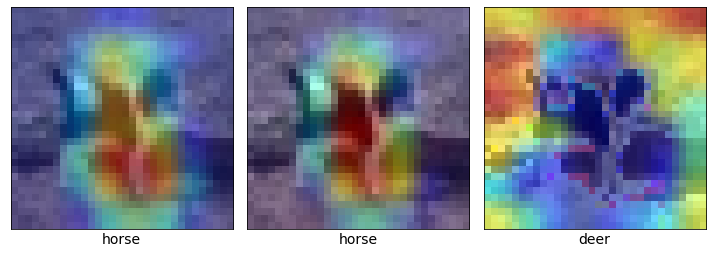

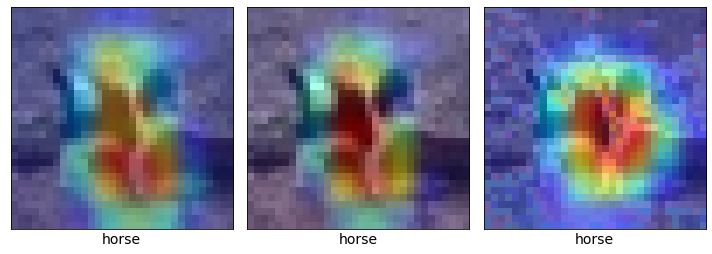

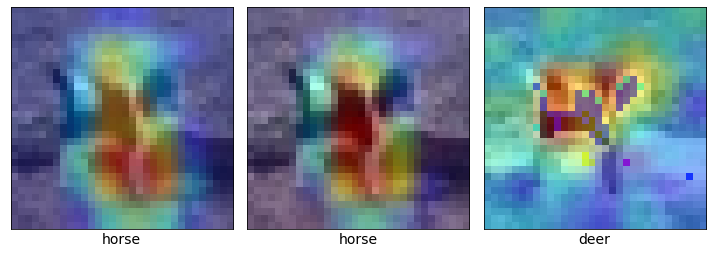

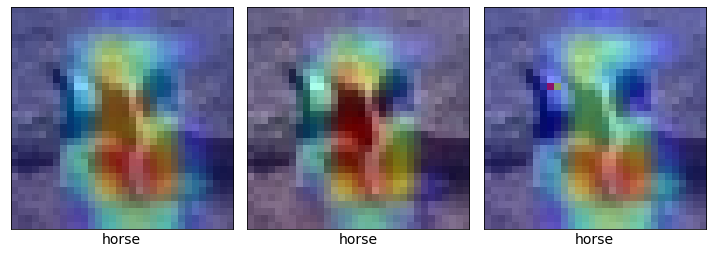

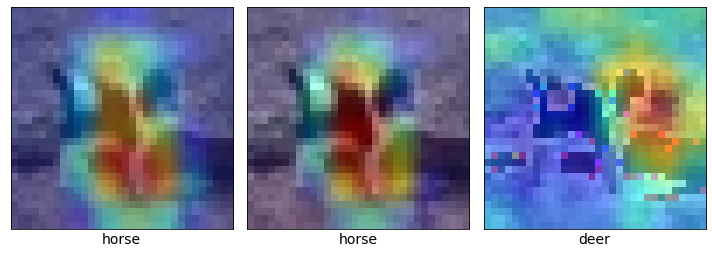

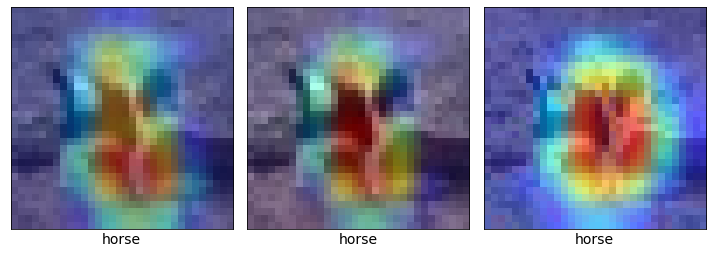

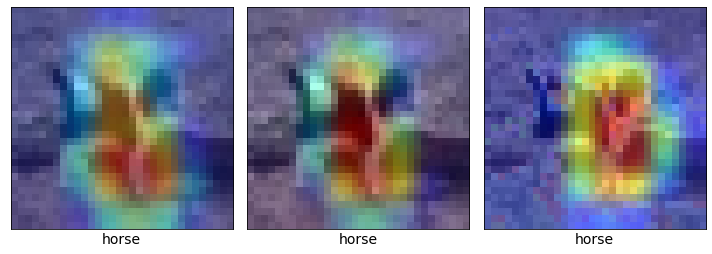

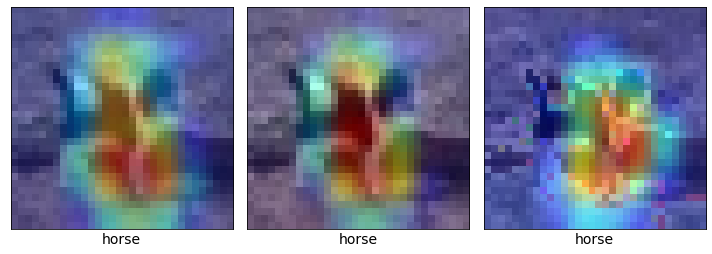

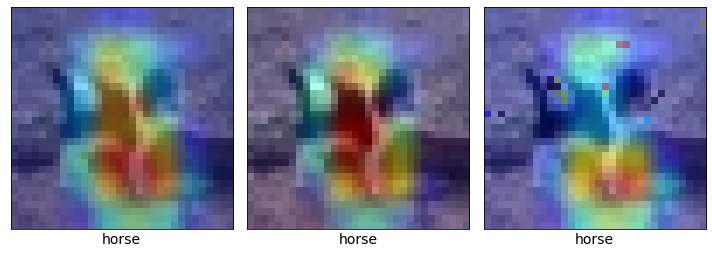

In [754]:
it = iter(tfds.as_numpy(test_grad.unbatch().batch(1).take(1).repeat()))

classes = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
    "ship", "truck"
]

for i in range(10):
    (c_a, w_a, s_a, labels) = next(it)
    heatmap_c = make_gradcam_heatmap(c_a, model)
    heatmap_w = make_gradcam_heatmap(w_a, model)
    heatmap_s = make_gradcam_heatmap(s_a, model)
    heatmap_c_img = combine_heatmap_image(c_a, heatmap_c)
    heatmap_w_img = combine_heatmap_image(w_a, heatmap_w)
    heatmap_s_img = combine_heatmap_image(s_a, heatmap_s)

    f, axarr = plt.subplots(1, 3, figsize=(10, 10))

    axarr[0].imshow(heatmap_c_img[0])
    axarr[0].set_xlabel(classes[np.argmax(model(c_a), axis=1)[0]],
                           fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_xticks([], minor=True)
    axarr[0].set_yticks([])
    axarr[0].set_yticks([], minor=True)


    axarr[1].imshow(heatmap_w_img[0])
    axarr[1].set_xlabel(classes[np.argmax(model(w_a), axis=1)[0]],
                           fontsize=14)
    axarr[1].set_xticks([])
    axarr[1].set_xticks([], minor=True)
    axarr[1].set_yticks([])
    axarr[1].set_yticks([], minor=True)

    axarr[2].imshow(heatmap_s_img[0])
    axarr[2].set_xlabel(classes[np.argmax(model(s_a), axis=1)[0]],
                           fontsize=14)
    axarr[2].set_xticks([])
    axarr[2].set_xticks([], minor=True)
    axarr[2].set_yticks([])
    axarr[2].set_yticks([], minor=True)
    plt.tight_layout()